# Luciferase titres of rabies G mutant pseudovirus for validation assays

This produces the figure 1D in the paper and is the data analysis for the luciferase titres for pseudovirus expressing singly cloned rabies G mutants. Raw data is in the directory 'RawData'

Relevant files within 'RawData' directory:
- 240810_ValidationMuts-Redo.xlsx: contains the raw data for all 4 luciferase plates
- 240810_PlateMap.xlsx: contains plate maps for all 4 plates
- 240810_Mutant_List.xlsx: contains list of all mutants
- 240810_MutantColorSettings.xlsx: contains plotting settings for the actual figure


In [42]:
import pandas as pd
from matplotlib import pyplot as pl
import seaborn as sb
import numpy as np
import matplotlib.cm as cm
import scipy.stats
from matplotlib.colors import ListedColormap

In [43]:
def formatPlate(plate_df):
    plate_copy = plate_df.copy();

    #assign column values
    plate_copy['column'] = plate_copy['Well'].apply(lambda x: int(x[1:]));
    plate_copy['row'] = plate_copy['Well'].apply(lambda x: x[0])
    
    
    #background correction
    
    bg_rows = ['A','H']
    plate_background = plate_copy[plate_copy['row'].isin(bg_rows)];
    bg_values = plate_background['RLU'].tolist();
    median_bg = np.median(bg_values);

    
    plate_copy = plate_copy[plate_copy['row'].isin(bg_rows)==False];
    plate_copy['bg'] = median_bg;
    
    plate_copy['RLU_bg_correct'] = plate_copy['RLU'].apply(lambda x: x-median_bg);
    
    #assign effective volume virus
    #convert row into an ordinal dilution exponent
    plate_copy['exponent_dilution']=plate_copy['row'].apply(lambda x: ord(x)-65);
    plate_copy['dilution_factor'] = plate_copy['exponent_dilution'].apply(lambda x: 2**(x-1));
    plate_copy['vol_virus'] = 12.5/plate_copy['dilution_factor'];
    
    #calculate RLU/uL
    plate_copy['RLU_per_uL'] =  plate_copy['RLU_bg_correct']/plate_copy['vol_virus'];
    
    return plate_copy;

In [44]:
Plate1_data = pd.read_excel('RawData/240810_ValidationMuts-Redo.xlsx','Plate1');
Plate1_data['plate_num']=1;

Plate2_data = pd.read_excel('RawData/240810_ValidationMuts-Redo.xlsx','Plate2');
Plate2_data['plate_num']=2;

Plate3_data = pd.read_excel('RawData/240810_ValidationMuts-Redo.xlsx','Plate3');
Plate3_data['plate_num']=3;

Plate4_data = pd.read_excel('RawData/240810_ValidationMuts-Redo.xlsx','Plate4');
Plate4_data['plate_num']=4;



In [45]:
#import plate map and mutants.

plate_maps = pd.read_excel('RawData/240810_PlateMap.xlsx');
mutant_list = pd.read_excel('RawData/240810_Mutant_List.xlsx');
mutant_list = mutant_list.drop_duplicates(subset='mutant')

In [46]:
#okay let's process one of the plates, see if the data makes sense...
Plate1_data_reformat = formatPlate(Plate1_data)


Plate1_data_reformat = pd.merge(Plate1_data_reformat,plate_maps,how='left',on=['plate_num','column']);
Plate1_data_reformat = pd.merge(Plate1_data_reformat,mutant_list,how='left',on=['mutant']);
Plate1_data_reformat = Plate1_data_reformat.dropna()



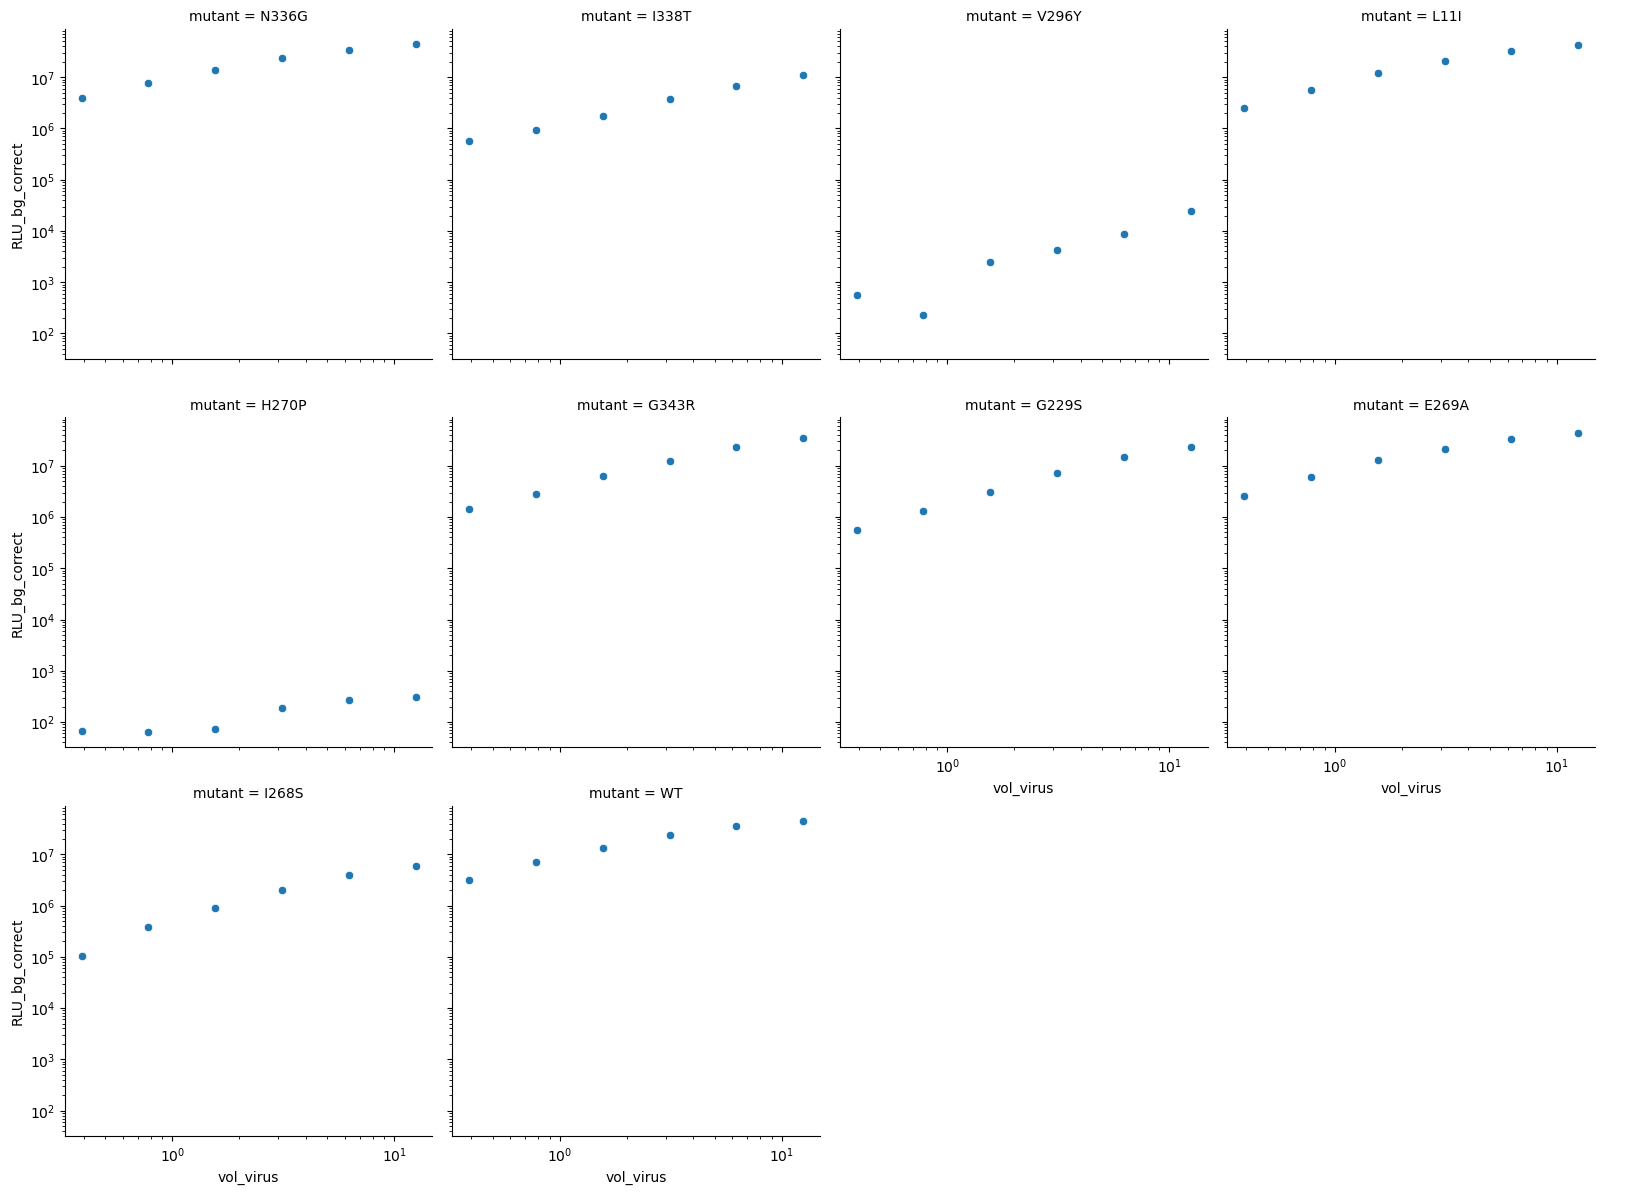

In [47]:
#okay let's do the facetgrid of plots

g = sb.FacetGrid(Plate1_data_reformat, col="mutant", col_wrap=4, height=4)

# Map the scatterplot to the FacetGrid
g = g.map(sb.scatterplot, "vol_virus", "RLU_bg_correct")

# Add legend
g.add_legend()

pl.xscale('log');
pl.yscale('log');
# Show plot
pl.show()

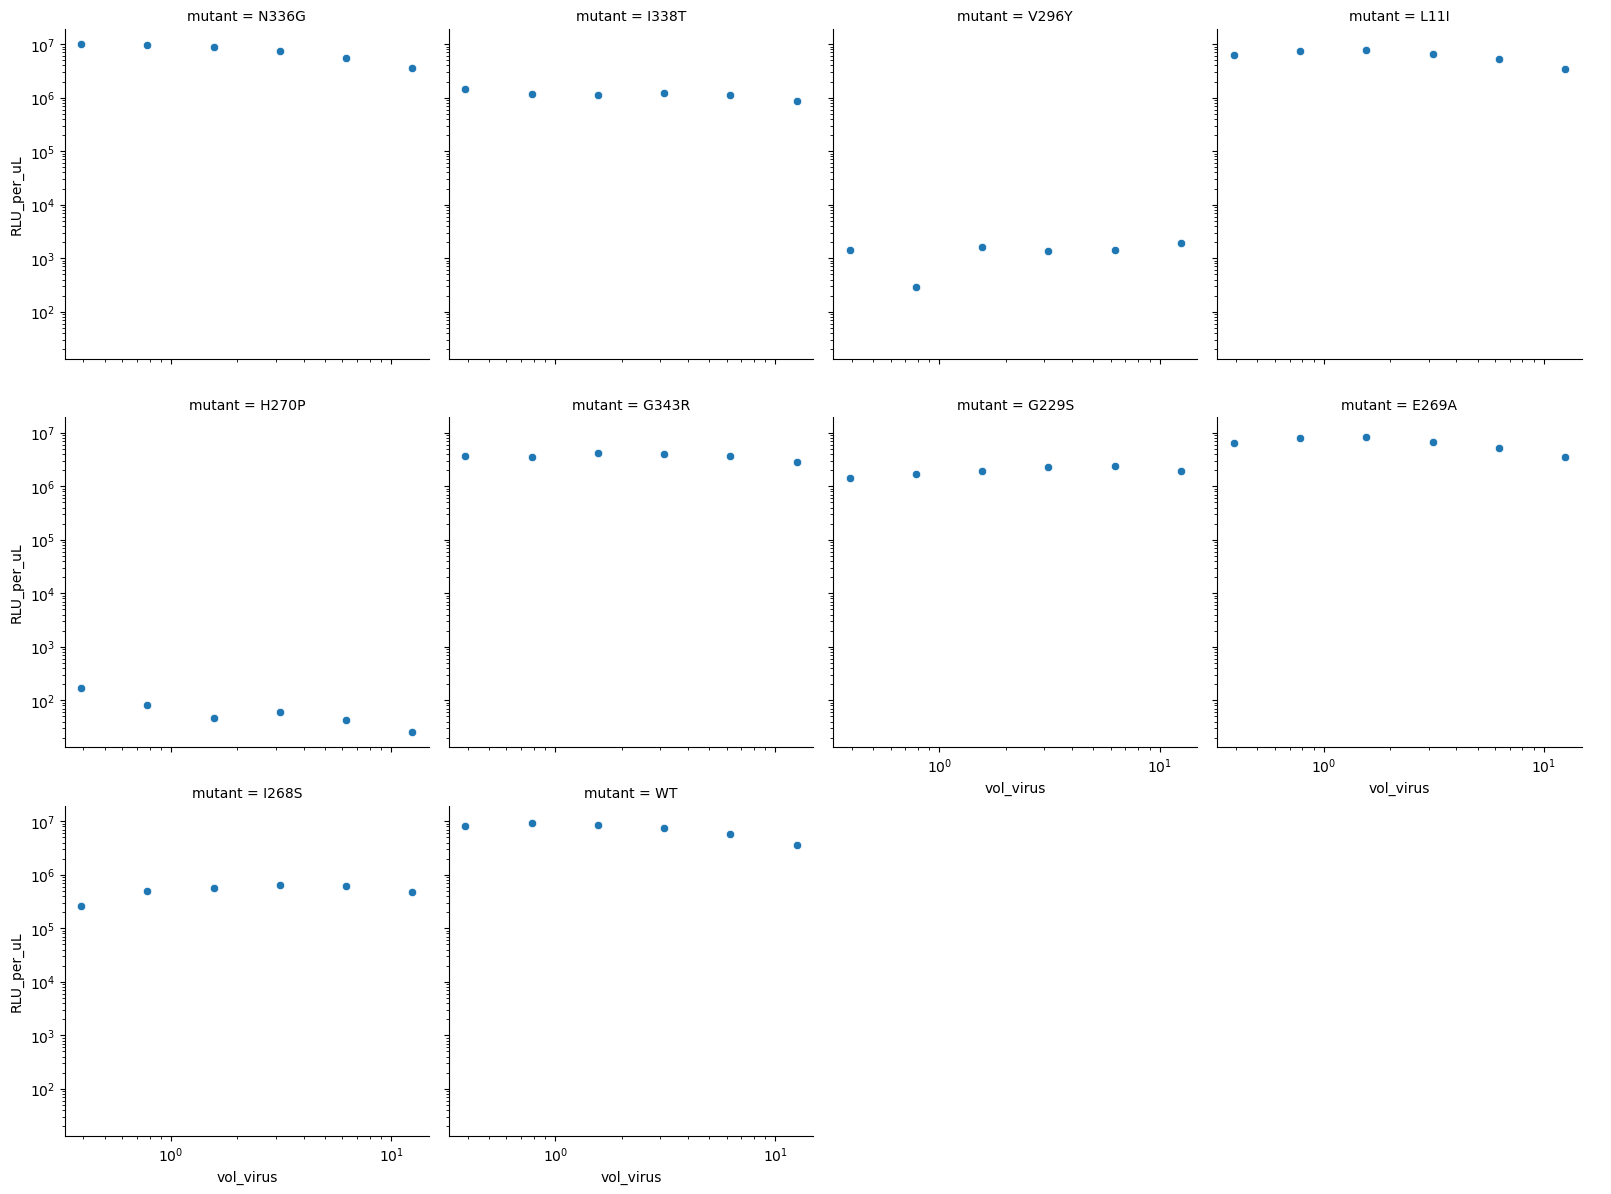

In [48]:
g= sb.FacetGrid(Plate1_data_reformat, col="mutant", col_wrap=4, height=4)

# Map the scatterplot to the FacetGrid
g = g.map(sb.scatterplot, "vol_virus", "RLU_per_uL")

# Add legend
g.add_legend()

pl.xscale('log');
pl.yscale('log');
# Show plot
pl.show()

#These look relatively consistent suggesting that the concentrations are not 
#swayed by a dynamic range limit on the platereader

In [49]:
#okay let's make a function that does all this

def tidy_df(plate_data,plate_map,mut_list):
    plate_data_copy = plate_data.copy();

    #join dfs and drop nan
    plate_data_copy = pd.merge(plate_data_copy,plate_map,how='left',on=['plate_num','column']);
    plate_data_copy = pd.merge(plate_data_copy,mut_list,how='left',on=['mutant']);
    plate_data_copy = plate_data_copy.dropna()

    #now confine the RLU values to range 10**3 to 10**6.5. I'll do this with a flag so that we have a handle to label things with on plots.
    plate_data_copy['plate_reader_flag']=plate_data_copy['RLU_bg_correct'].apply(lambda x: False if x >= 10**3 and x<=10**7.5 else True);

    #okay let's get RLU_mut versus RLU_WT. I'll do this by getting the wildtype, gather median, and just normalize.
    plate_data_copy_withinRange = plate_data_copy[plate_data_copy['plate_reader_flag']==False];
    plate_data_copy_withinRange_wt = plate_data_copy_withinRange[plate_data_copy_withinRange['mutant']=='WT'];
    list_RLU_per_uL = plate_data_copy_withinRange_wt['RLU_per_uL'].tolist();
    mean_wt_RLU_per_uL = np.mean(list_RLU_per_uL);

    plate_data_copy['percent_wt']= plate_data_copy['RLU_per_uL']/mean_wt_RLU_per_uL;
    plate_data_copy['mean_wt_RLU_per_uL']=mean_wt_RLU_per_uL;

    return plate_data_copy;

In [50]:
Plate1_data_reformat = formatPlate(Plate1_data);
Plate1_data_tidy = tidy_df(Plate1_data_reformat,plate_maps,mutant_list);

Plate2_data_reformat = formatPlate(Plate2_data);
Plate2_data_tidy = tidy_df(Plate2_data_reformat,plate_maps,mutant_list);

Plate3_data_reformat = formatPlate(Plate3_data);
Plate3_data_tidy = tidy_df(Plate3_data_reformat,plate_maps,mutant_list);

Plate4_data_reformat = formatPlate(Plate4_data);
Plate4_data_tidy = tidy_df(Plate4_data_reformat,plate_maps,mutant_list);


dfs = [Plate1_data_tidy,Plate2_data_tidy,Plate3_data_tidy,Plate4_data_tidy];
final = pd.concat(dfs);

#I decided not to use the plate reader flag as that would exclude known dead variants for which we need results

In [51]:
final

,Well,Group,Type,Sample,RLU,Time [s],plate_num,column,row,bg,...,exponent_dilution,dilution_factor,vol_virus,RLU_per_uL,mutant,batch_virus,functional_score,plate_reader_flag,percent_wt,mean_wt_RLU_per_uL
1,B11,Group 1,Unknown,Un0023,4.507000e+07,16.99,1,11,B,19.845,...,1,1,12.500000,3.605598e+06,N336G,batch_1,0.151,True,0.432767,8.331496e+06
2,B10,Group 1,Unknown,Un0022,1.084000e+07,18.48,1,10,B,19.845,...,1,1,12.500000,8.671984e+05,I338T,batch_1,-1.750,False,0.104087,8.331496e+06
3,B09,Group 1,Unknown,Un0021,2.453000e+04,19.94,1,9,B,19.845,...,1,1,12.500000,1.960812e+03,V296Y,batch_1,-3.510,False,0.000235,8.331496e+06
4,B08,Group 1,Unknown,Un0020,4.323000e+07,21.94,1,8,B,19.845,...,1,1,12.500000,3.458398e+06,L11I,batch_1,0.440,True,0.415099,8.331496e+06
5,B07,Group 1,Unknown,Un0019,3.333000e+02,23.69,1,7,B,19.845,...,1,1,12.500000,2.507640e+01,H270P,batch_1,-6.750,True,0.000003,8.331496e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,G06,Group 1,Unknown,Un0366,2.440000e+05,624.42,4,6,G,7.451,...,6,32,0.390625,6.246209e+05,S341D,batch_2,-0.239,False,0.934235,6.685911e+05
66,G07,Group 1,Unknown,Un0367,2.557000e+05,625.67,4,7,G,7.451,...,6,32,0.390625,6.545729e+05,S341Y,batch_2,-0.353,False,0.979033,6.685911e+05
67,G08,Group 1,Unknown,Un0368,-4.164000e+00,626.92,4,8,G,7.451,...,6,32,0.390625,-2.973440e+01,N319A,batch_2,-7.000,True,-0.000044,6.685911e+05
68,G09,Group 1,Unknown,Un0369,7.367000e+04,628.17,4,9,G,7.451,...,6,32,0.390625,1.885761e+05,I338T,batch_2,-1.750,False,0.282050,6.685911e+05


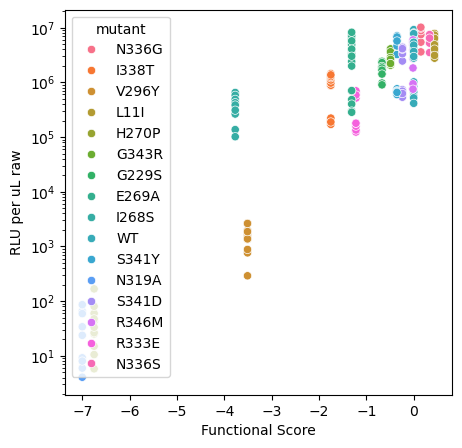

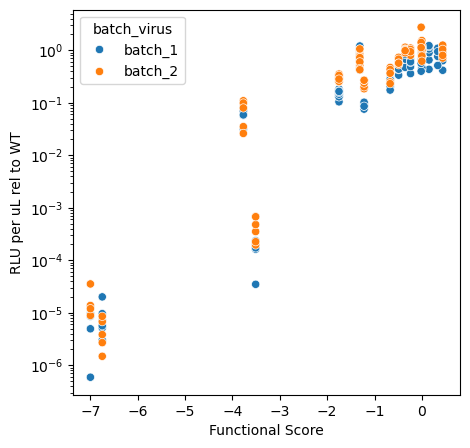

In [52]:
#okay let's go ahead and plot these things crudely.


# Create the scatterplot
pl.figure(figsize=(5,5))
sb.scatterplot(x='functional_score',y='RLU_per_uL',hue='mutant',data=final)

# Set y-axis to logarithmic scale
pl.yscale('log')


# Add labels and title
pl.xlabel('Functional Score')
pl.ylabel('RLU per uL raw')


# Show the plot
pl.show()


# Create the scatterplot
pl.figure(figsize=(5,5))
sb.scatterplot(x='functional_score',y='percent_wt',hue='batch_virus',data=final)

# Set y-axis to logarithmic scale
pl.yscale('log')


# Add labels and title
pl.xlabel('Functional Score')
pl.ylabel('RLU per uL rel to WT')


# Show the plot
pl.show()

#clearly we can see that per-plate normalization to WT is actually helping out. 

In [53]:
#okay so we want to go ahead and collapse by mutant and by batch and take the mean RLU/uL reltive to Unmutated.

grouped_df= final.groupby(['mutant','batch_virus'])['percent_wt'].mean().reset_index();


In [54]:
grouped_df = pd.merge(grouped_df,mutant_list,how='left',on='mutant')

In [55]:
grouped_df['percent_wt_clipped'] = grouped_df['percent_wt'].clip(lower=10**-4)
grouped_df['functional_score_clipped'] = grouped_df['functional_score'].clip(lower=-5)

In [56]:
grouped_df

,mutant,batch_virus,percent_wt,functional_score,percent_wt_clipped,functional_score_clipped
0,E269A,batch_1,8.137260e-01,-1.310,0.813726,-1.310
1,E269A,batch_2,7.573248e-01,-1.310,0.757325,-1.310
2,G229S,batch_1,2.343133e-01,-0.670,0.234313,-0.670
3,G229S,batch_2,3.508958e-01,-0.670,0.350896,-0.670
4,G343R,batch_1,4.353484e-01,-0.490,0.435348,-0.490
5,G343R,batch_2,6.076626e-01,-0.490,0.607663,-0.490
6,H270P,batch_1,8.454256e-06,-6.750,0.000100,-5.000
7,H270P,batch_2,3.008419e-06,-6.750,0.000100,-5.000
8,I268S,batch_1,6.195630e-02,-3.770,0.061956,-3.770
9,I268S,batch_2,7.433371e-02,-3.770,0.074334,-3.770


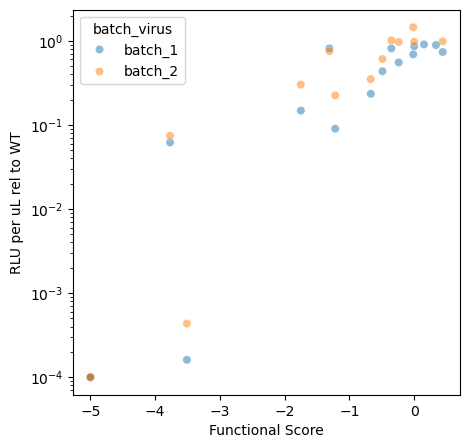

In [57]:
# Create the scatterplot
pl.figure(figsize=(5,5))
sb.scatterplot(x='functional_score_clipped',y='percent_wt_clipped',hue='batch_virus',data=grouped_df,alpha = 0.5)

# Set y-axis to logarithmic scale
pl.yscale('log')


# Add labels and title
pl.xlabel('Functional Score')
pl.ylabel('RLU per uL rel to WT')


# Show the plot
pl.show()

In [58]:
#okay we need to go ahead and assign marker and colors to each mutant.

markercolors = pd.read_excel('RawData/240810_MutantColorSettings.xlsx');

grouped_df=pd.merge(grouped_df,markercolors,how='left',on='mutant')

In [59]:
grouped_df

,mutant,batch_virus,percent_wt,functional_score,percent_wt_clipped,functional_score_clipped,marker,color
0,E269A,batch_1,8.137260e-01,-1.310,0.813726,-1.310,o,#54a24b
1,E269A,batch_2,7.573248e-01,-1.310,0.757325,-1.310,o,#54a24b
2,G229S,batch_1,2.343133e-01,-0.670,0.234313,-0.670,o,#b279a2
3,G229S,batch_2,3.508958e-01,-0.670,0.350896,-0.670,o,#b279a2
4,G343R,batch_1,4.353484e-01,-0.490,0.435348,-0.490,<,#54a24b
5,G343R,batch_2,6.076626e-01,-0.490,0.607663,-0.490,<,#54a24b
6,H270P,batch_1,8.454256e-06,-6.750,0.000100,-5.000,p,#f58518
7,H270P,batch_2,3.008419e-06,-6.750,0.000100,-5.000,p,#f58518
8,I268S,batch_1,6.195630e-02,-3.770,0.061956,-3.770,o,#b79a20
9,I268S,batch_2,7.433371e-02,-3.770,0.074334,-3.770,o,#b79a20


In [60]:
#okay this is cosmetic but we want to order the dataframe by position number 

grouped_df['site']=grouped_df['mutant'].apply(lambda x: x[1:-1]);

grouped_df = grouped_df.sort_values(by=['site'])

In [61]:
 grouped_df

,mutant,batch_virus,percent_wt,functional_score,percent_wt_clipped,functional_score_clipped,marker,color,site
29,WT,batch_2,9.761484e-01,0.000,0.976148,0.000,s,#79706e,
28,WT,batch_1,8.604774e-01,0.000,0.860477,0.000,s,#79706e,
13,L11I,batch_2,9.870824e-01,0.440,0.987082,0.440,o,#4c78a8,11
12,L11I,batch_1,7.361891e-01,0.440,0.736189,0.440,o,#4c78a8,11
2,G229S,batch_1,2.343133e-01,-0.670,0.234313,-0.670,o,#b279a2,229
3,G229S,batch_2,3.508958e-01,-0.670,0.350896,-0.670,o,#b279a2,229
9,I268S,batch_2,7.433371e-02,-3.770,0.074334,-3.770,o,#b79a20,268
8,I268S,batch_1,6.195630e-02,-3.770,0.061956,-3.770,o,#b79a20,268
0,E269A,batch_1,8.137260e-01,-1.310,0.813726,-1.310,o,#54a24b,269
1,E269A,batch_2,7.573248e-01,-1.310,0.757325,-1.310,o,#54a24b,269


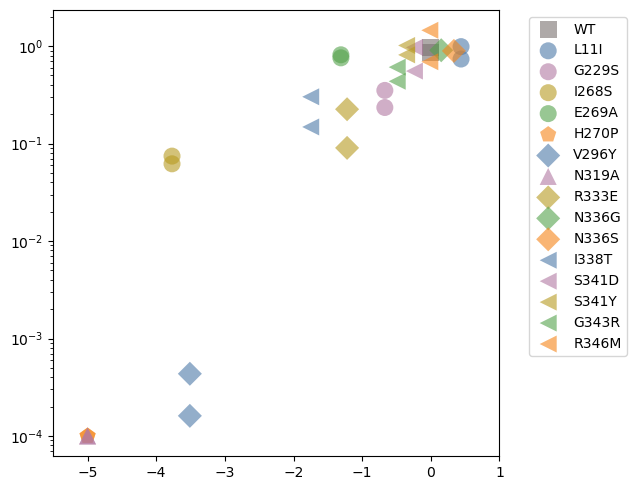

In [62]:
fig, ax = pl.subplots(figsize=(6.5,5))

added_labels = []
handles = []

# Plot using Seaborn
for _, row in grouped_df.iterrows():
    if row['mutant'] not in added_labels:
        plot = sb.scatterplot(
            x=[row['functional_score_clipped']],
            y=[row['percent_wt_clipped']],
            marker=row['marker'],
            color=row['color'],
            s=150,  # Size of markers
            label=row['mutant'],  # Add label for legend
            alpha=0.6,
            edgecolor='none'
        )
        added_labels.append(row['mutant'])
        handles.append(plot.collections[-1])
    else:
        sb.scatterplot(
            x=[row['functional_score_clipped']],
            y=[row['percent_wt_clipped']],
            marker=row['marker'],
            color=row['color'],
            s=150,  # Size of markers
            alpha=0.6,
            edgecolor='none'
        )

pl.legend(handles=handles, labels=added_labels, bbox_to_anchor=(1.05, 1), loc='upper left')  # Position legend outside the plot
pl.xlim(-5.5, 1)
pl.yscale('log')
pl.tight_layout()
pl.show()


#fig.savefig('2401810_ValidationMuts.eps');

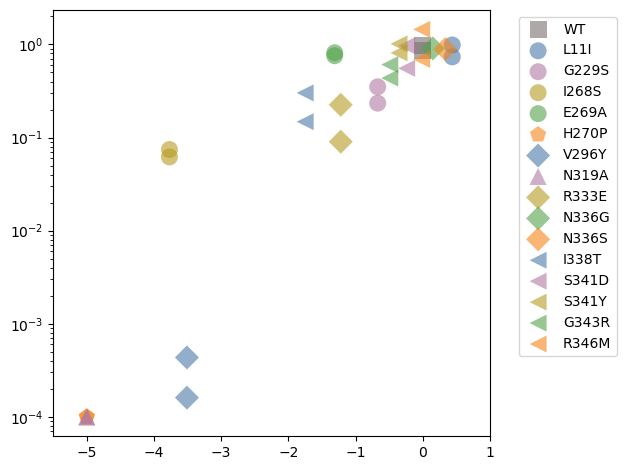

In [63]:
# Lists to store the correct handles and labels
handles = []
labels = []

# Plot using Seaborn
for _, row in grouped_df.iterrows():
    scatter = sb.scatterplot(
        x=[row['functional_score_clipped']],
        y=[row['percent_wt_clipped']],
        marker=row['marker'],
        color=row['color'],
        s=150,  # Size of markers
        alpha=0.6,
        edgecolor='none'
    )

    # Store handle and label for the first appearance of each mutant
    if row['mutant'] not in labels:
        handles.append(scatter.collections[-1])  # Correct handle for scatter points
        labels.append(row['mutant'])

# Create the legend using the correct handles and labels in the correct order
pl.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc='upper left')

pl.xlim(-5.5, 1)
pl.yscale('log')
pl.tight_layout()
pl.show()

In [64]:
#let me get an r value from an arbitrary linear model.


grouped_df['percent_wt_clipped_log10'] = grouped_df['percent_wt_clipped'].apply(lambda x: np.log10(x))

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(grouped_df['functional_score_clipped'], grouped_df['percent_wt_clipped_log10'])
r_value


0.9139377402929623